## Importing Libraries

In [ ]:
!pip install transformers==4.28.0
# !pip install git+https://github.com/huggingface/transformers
# !pip install --upgrade transformers
# !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.9 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from google.colab import drive
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments, AutoModelWithLMHead, TextDataset, DataCollatorForLanguageModeling, pipeline, GPT2LMHeadModel, GPT2Tokenizer#take the input text then encode it from text to numbers
import shutil

# Reading Data
-------------------

In [ ]:
#mount google drive to the colab runtime
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
csv_data = pd.read_csv('/content/drive/MyDrive/merged_data.csv')

In [ ]:
csv_data

,Unnamed: 0,Verse,Meter,char_count
0,0,ah why this boding start this sudden pain,iambic,6
1,1,that wings my pulse and shoots from vein to vein,iambic,6
2,2,what mean regardless of yon midnight bell,iambic,6
3,3,these earthborn visions saddening o'er my cell,iambic,6
4,4,what strange disorder prompts these thoughts t...,iambic,6
...,...,...,...,...
198997,202272,were mellow music matchd with him,iambic,6
198998,202274,o life as futile then as frail,iambic,6
198999,202275,o for thy voice to soothe and bless,iambic,6
199000,202276,what hope of answer or redress,iambic,6


The dataset consists of 4 columns, we are interested on the "Verse" one only. It contains 199002 sample(verse), I decided to train the model with 16000 sample due to the resource limitation I have.

In [ ]:
csv_data['Meter'].head(16000).unique()

array(['iambic', 'anapaestic', 'trochaic'], dtype=object)

In [ ]:
csv_data = csv_data[['Verse']]

In [ ]:
csv_data

,Verse
0,ah why this boding start this sudden pain
1,that wings my pulse and shoots from vein to vein
2,what mean regardless of yon midnight bell
3,these earthborn visions saddening o'er my cell
4,what strange disorder prompts these thoughts t...
...,...
198997,were mellow music matchd with him
198998,o life as futile then as frail
198999,o for thy voice to soothe and bless
199000,what hope of answer or redress


## Preparing the Corpus

In [ ]:
corpus = csv_data['Verse'].to_list()[0: 16000]

In [ ]:
corpus[0: 4]

['ah why this boding start this sudden pain',
 'that wings my pulse and shoots from vein to vein',
 'what mean regardless of yon midnight bell',
 "these earthborn visions saddening o'er my cell"]

Get the length of each verse, where length represent number of words in that verse


In [ ]:
verse_length = [len(line.split(' ')) for line in corpus]
verse_length[0: 5]

[8, 10, 7, 7, 8]

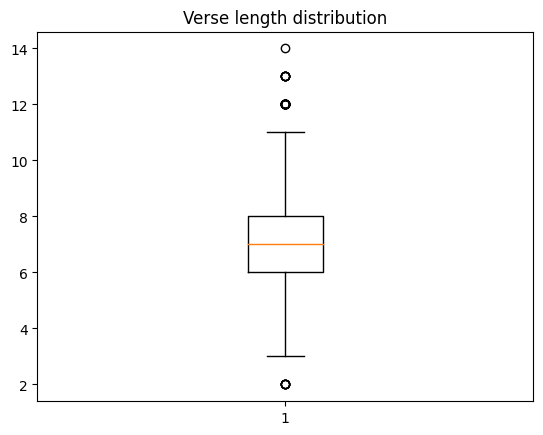

In [ ]:
plt.boxplot(verse_length)
plt.title('Verse length distribution')
plt.show()

In [ ]:
print(
    f'Longest verse has {max(verse_length)} word.'
    f'\nShorter one has {min(verse_length)}.'
    f'\n{int(np.mean(verse_length))} is the mean number of words per verse.\n'
)

Longest verse has 14 word.
Shorter one has 2.
7 is the mean number of words per verse.



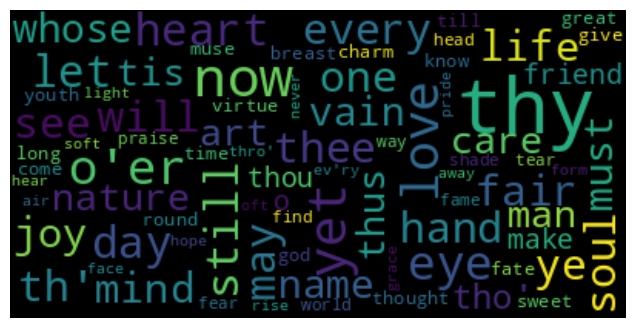

In [ ]:
# Generating the wordCloud to visiualize the text
wordcloud = WordCloud(max_font_size=50,
                      max_words=80,
                      background_color="black").generate(" ".join(corpus))

# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

## Text Preprocessing

Making samples, that I'll use in the training, consistant by converting letters to lower case.

> 1. Convert to lower case

In [ ]:
corpus = [sentence.lower() for sentence in corpus]

-----------------------------
# GPT-2 Fine Tunning

In [ ]:
df = pd.DataFrame(corpus, columns = ['verse'])
df

,verse
0,ah why this boding start this sudden pain
1,that wings my pulse and shoots from vein to vein
2,what mean regardless of yon midnight bell
3,these earthborn visions saddening o'er my cell
4,what strange disorder prompts these thoughts t...
...,...
15995,for ever lives the particle divine
15996,yet make myy tomb to future ages known
15997,and with a modest verse inscribe the stone
15998,the verse shall preach some moral truth to man


#### Write verses into a text file so they can be used while the training using the generator.

In [ ]:
df.to_csv(
    r'full_text.txt',
    header=None,
    index=None,
    sep=' ',
    mode='a'
    )

#### Load the GPT-2 model with its tokenizer

In [ ]:
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id = gpt_tokenizer.eos_token_id)

In [ ]:
gpt_tokenizer.decode(gpt_tokenizer.eos_token_id)

'<|endoftext|>'

In [ ]:
corpus[:5]

['ah why this boding start this sudden pain',
 'that wings my pulse and shoots from vein to vein',
 'what mean regardless of yon midnight bell',
 "these earthborn visions saddening o'er my cell",
 'what strange disorder prompts these thoughts to glow']

### Splitting the data into train, and test without shuffeling.

In [ ]:
train_path = '/content/train_dataset.txt'
test_path = '/content/test_dataset.txt'

In [ ]:
train, test = train_test_split(
    df,
    test_size=0.15,
    shuffle=False
    )

Write train and test data each one into distinct text file.

In [ ]:
train.to_csv(
    r'train_dataset.txt',
    header=None,
    index=None,
    sep=' ',
    mode='a'
    )

test.to_csv(
    r'test_dataset.txt',
    header=None,
    index=None,
    sep=' ',
    mode='a'
    )

#### Remove double qoutes that were added to verses after writing them in the text file.

In [ ]:
def remove_double_qoutes(file_path: str) -> None:

    # Read the file
    with open(file_path, 'r') as file:
        text = file.read()

    # Remove double quotes
    text_without_quotes = text.replace('"', '')

    # Write the modified text back to the file
    with open(file_path, 'w') as file:
        file.write(text_without_quotes)

In [ ]:
remove_double_qoutes(train_path)
remove_double_qoutes(test_path)

### Define load_dataset function that will load and prepare the dataset for the model.

In [ ]:
def load_dataset(train_path, test_path, tokenizer):

    train_dataset = TextDataset(
          tokenizer = gpt_tokenizer,
          file_path = train_path,
          #maximum sequence length
          block_size=128
          )

    test_dataset = TextDataset(
          tokenizer = gpt_tokenizer,
          file_path = test_path,
          block_size=128
          )

    data_collator = DataCollatorForLanguageModeling(
        tokenizer = gpt_tokenizer,
        mlm=False
    )

    return train_dataset, test_dataset, data_collator

In [ ]:
train_dataset, test_dataset, data_collator = load_dataset(train_path, test_path, gpt_tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
# !pip install --upgrade accelerate

In [ ]:
training_args = TrainingArguments(
    #The output directory
    output_dir = "./gpt2-Poems",
    #overwrite the content of the output directory
    overwrite_output_dir = True,
    # number of training epochs
    num_train_epochs = 15,
    # batch size for training
    per_device_train_batch_size=32,
    # batch size for evaluation
    per_device_eval_batch_size=64,
    # Number of update steps between two evaluations.
    eval_steps = 400,
    # after # steps model is saved
    save_steps=800,
    # number of warmup steps for learning rate scheduler
    warmup_steps=500,
    )

#initialize a trainer object to train the GPT-2 model using my data and training settings.
trainer = Trainer(
    model=gpt_model,
    args=training_args,
    data_collator=data_collator,  #collate and batch the data, tokenize verses
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

### Train the model

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=495, training_loss=4.813403073705808, metrics={'train_runtime': 563.5174, 'train_samples_per_second': 27.816, 'train_steps_per_second': 0.878, 'total_flos': 1023938150400000.0, 'train_loss': 4.813403073705808, 'epoch': 15.0})

## Save the model

In [ ]:
# trainer.save_model('./gpt_for_poems')

# # Compress the folder into a zip file
# shutil.make_archive("/content/gpt_for_poems", "zip", "/content/gpt_for_poems")


'/content/gpt_for_poems.zip'

In [ ]:
df['similarity'].describe()

count    150.000000
mean       0.180083
std        0.107258
min       -0.068467
25%        0.106643
50%        0.167557
75%        0.244395
max        0.622846
Name: similarity, dtype: float64